This notebook demonstrates a complete trading system with:
 - Multi-asset market data loading
 - Order management system (OMS)
 - Limit order book matching engine
 - Position tracking and P&L calculation
 - Three trading strategies: trend-following, mean reversion, and arbitrage
 
 ## System Architecture
 
 ```
 MarketDataLoader → Strategy → OMS → OrderBook → PositionTracker
                      ↓              ↓           ↓
                   Signals      ExecutionReports  P&L
 ```

# 1. Market Data Loading and Exploration

In [1]:
# %%
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Our trading system components
from market_data_loader import MarketDataLoader
from order import Order
from oms import OrderManagementSystem
from order_book import LimitOrderBook
from position_tracker import PositionTracker

# Trading strategies
from strategies.trend_following import run_backtest as tf_backtest
from strategies.mean_reversion import run_backtest as mr_backtest
from strategies.arbitrage import run_backtest as arb_backtest

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Fetch data for multiple assets
symbols = ["AAPL", "MSFT", "GOOGL", "SPY", "QQQ"]
data = {}
loader = MarketDataLoader()

print("📊 Fetching market data...")
for symbol in symbols:
    try:
        hist = loader.get_history(symbol)
        data[symbol] = hist
        print(f"✅ {symbol}: {len(hist)} days, ${hist['last_price'].iloc[-1]:.2f}")
    except Exception as e:
        print(f"❌ {symbol}: {e}")

# Show sample data
if "AAPL" in data:
    print("\n📈 Sample AAPL data:")
    print(data["AAPL"].head())

📊 Fetching market data...
✅ AAPL: 250 days, $214.05
✅ MSFT: 250 days, $512.50
✅ GOOGL: 250 days, $192.58
✅ SPY: 250 days, $636.90
✅ QQQ: 250 days, $568.14

📈 Sample AAPL data:
Price                      last_price        high         low        open  \
Date                                                                        
2024-07-29 00:00:00+00:00  217.224121  218.279184  214.745706  215.950081   
2024-07-30 00:00:00+00:00  217.781509  219.304386  215.113977  218.169693   
2024-07-31 00:00:00+00:00  221.046234  222.778140  219.602987  220.409214   
2024-08-01 00:00:00+00:00  217.343552  223.435059  216.009793  223.325570   
2024-08-02 00:00:00+00:00  218.836578  224.549865  216.696592  218.129877   

Price                         volume  
Date                                  
2024-07-29 00:00:00+00:00   36311800  
2024-07-30 00:00:00+00:00   41643800  
2024-07-31 00:00:00+00:00   50036300  
2024-08-01 00:00:00+00:00   62501000  
2024-08-02 00:00:00+00:00  105568600  


# 2. Trading System Components Demo

In [12]:
# Demonstrate core trading infrastructure
print("🔧 Testing Trading Infrastructure...")

# Initialize components
oms = OrderManagementSystem()
book = LimitOrderBook("DEMO")
tracker = PositionTracker(starting_cash=100000)

# Create sample orders
orders = [
    Order("BUY1", "DEMO", "buy", 100, "limit", 150.0),
    Order("SELL1", "DEMO", "sell", 50, "limit", 149.0),  # Should match
    Order("BUY2", "DEMO", "buy", 200, "market")  # Market order
]

print("\n📋 Order Management System Test:")
for order in orders:
    try:
        # Submit to OMS
        ack = oms.new_order(order)
        print(f"✅ {order}: {ack['status']}")
        
        # Route to order book
        reports = book.add_order(order)
        print(f"   💱 Generated {len(reports)} execution reports")
        
        # Update position tracker
        for report in reports:
            tracker.update(report)
            
    except Exception as e:
        print(f"❌ {order}: {e}")

# Show final state
print(f"\n💰 Final Portfolio:")
print(f"   Cash: ${tracker.cash:,.2f}")
print(f"   Positions: {tracker.positions}")
print(f"   Book State: {book}")

🔧 Testing Trading Infrastructure...

📋 Order Management System Test:
✅ Order(BUY1: BUY 100 DEMO limit @$150.00): accepted
   💱 Generated 0 execution reports
✅ Order(SELL1: SELL 50 DEMO limit @$149.00): accepted
   💱 Generated 2 execution reports
✅ Order(BUY2: BUY 200 DEMO market @market): accepted
   💱 Generated 0 execution reports

💰 Final Portfolio:
   Cash: $100,000.00
   Positions: {'DEMO': 0}


ValueError: Invalid format specifier '.2f if best_bid else 'None'' for object of type 'float'

# 3. Strategy 
    1: Trend Following

📈 Running Trend Following Strategy on AAPL...

🎯 Trend Following Results:
   strategy: trend_following
   total_return: -2.30%
   total_pnl: -2297.32
   max_drawdown: 0.000
   sharpe_ratio: 0.000
   win_rate: 0
   avg_win: 0
   avg_loss: 0
   total_trades: 1
   final_position: 82
   final_cash: 80150.58
   short_window: 20
   long_window: 50
   starting_cash: 100000


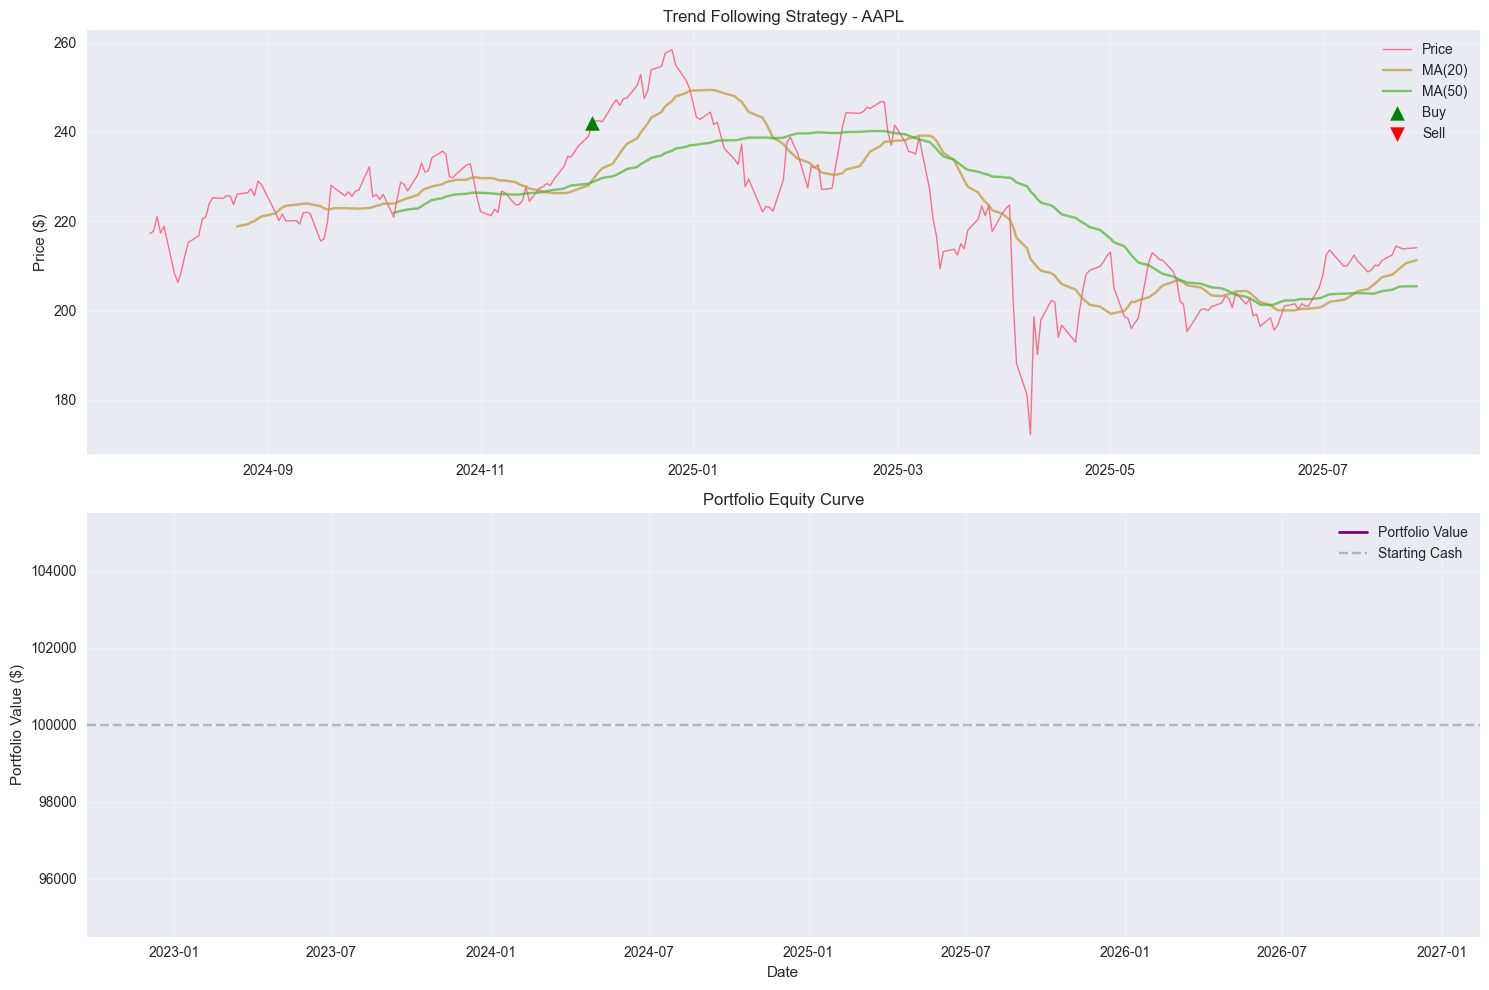

In [13]:
# Trend Following Strategy on AAPL
if "AAPL" in data:
    print("📈 Running Trend Following Strategy on AAPL...")
    
    # Run backtest
    tf_signals, tf_trades, tf_metrics = tf_backtest(
        data["AAPL"], 
        short_win=20, 
        long_win=50,
        risk_params={
            "max_position": 100,
            "position_pct": 0.2
        },
        starting_cash=100000
    )
    
    # Display results
    print(f"\n🎯 Trend Following Results:")
    for key, value in tf_metrics.items():
        if isinstance(value, float):
            if 'return' in key or 'rate' in key:
                print(f"   {key}: {value:.2%}")
            elif 'ratio' in key or 'drawdown' in key:
                print(f"   {key}: {value:.3f}")
            else:
                print(f"   {key}: {value:.2f}")
        else:
            print(f"   {key}: {value}")
    
    # Plot signals and equity curve
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Price and moving averages
    ax1 = axes[0]
    price_data = data["AAPL"].join(tf_signals[['ma_short', 'ma_long']])
    ax1.plot(price_data.index, price_data['last_price'], label='Price', linewidth=1)
    ax1.plot(price_data.index, price_data['ma_short'], label=f'MA({tf_metrics["short_window"]})', alpha=0.7)
    ax1.plot(price_data.index, price_data['ma_long'], label=f'MA({tf_metrics["long_window"]})', alpha=0.7)
    
    # Mark trades
    if tf_trades:
        trades_df = pd.DataFrame(tf_trades)
        buy_trades = trades_df[trades_df['side'] == 'buy']
        sell_trades = trades_df[trades_df['side'] == 'sell']
        
        ax1.scatter(buy_trades['timestamp'], buy_trades['price'], 
                   color='green', marker='^', s=100, label='Buy', zorder=5)
        ax1.scatter(sell_trades['timestamp'], sell_trades['price'], 
                   color='red', marker='v', s=100, label='Sell', zorder=5)
    
    ax1.set_title('Trend Following Strategy - AAPL')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Equity curve (simplified)
    ax2 = axes[1]
    if tf_trades:
        # Create simple equity curve from trades
        equity_points = []
        running_pnl = 0
        position = 0
        
        for trade in tf_trades:
            if trade['side'] == 'buy':
                position += trade['quantity']
            else:
                if position > 0:
                    pnl = (trade['price'] - tf_trades[0]['price']) * trade['quantity']
                    running_pnl += pnl
                position -= trade['quantity']
            
            equity_points.append({
                'timestamp': trade['timestamp'],
                'equity': tf_metrics['starting_cash'] + running_pnl
            })
        
        if equity_points:
            equity_df = pd.DataFrame(equity_points)
            ax2.plot(equity_df['timestamp'], equity_df['equity'], 
                    label='Portfolio Value', color='purple', linewidth=2)
    
    ax2.axhline(y=tf_metrics['starting_cash'], color='gray', linestyle='--', alpha=0.5, label='Starting Cash')
    ax2.set_title('Portfolio Equity Curve')
    ax2.set_ylabel('Portfolio Value ($)')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. Strategy
    2: Mean Reversion

🔄 Running Mean Reversion Strategy on SPY...

🎯 Mean Reversion Results:
   strategy: mean_reversion
   total_return: -0.96%
   total_pnl: -962.52
   max_drawdown: -0.027
   sharpe_ratio: 0.085
   win_rate: 1.05%
   total_trades: 7
   final_position: -23
   final_cash: 113686.18
   bollinger_window: 20
   num_std: 2.00
   starting_cash: 100000
   trade_reasons: {'overbought_entry': 3, 'stop_loss': 2, 'max_hold_period': 1, 'oversold_entry': 1}
   avg_entry_bb_position: 0.74
   avg_bb_width: 0.04


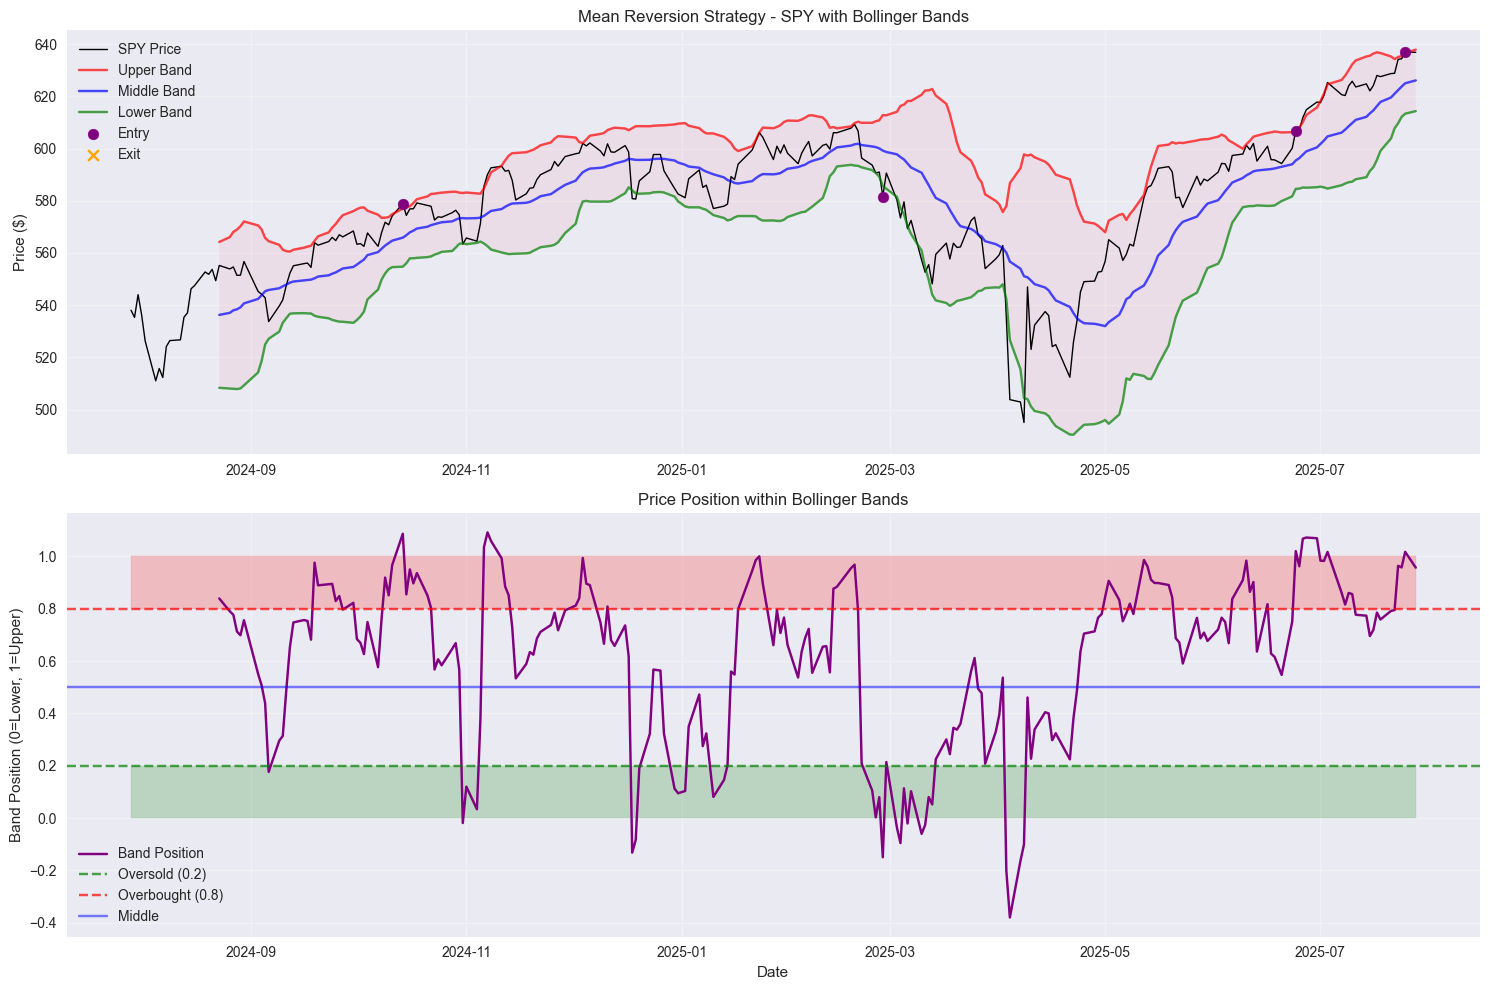

In [18]:
# Mean Reversion Strategy on SPY
if "SPY" in data:
    print("🔄 Running Mean Reversion Strategy on SPY...")
    
    # Run backtest
    mr_signals, mr_trades, mr_metrics = mr_backtest(
        data["SPY"],
        bollinger_win=20,
        num_std=2.0,
        risk_params={
            "max_position": 50,
            "position_pct": 0.15,
            "hold_periods": 10,
            "stop_loss": 0.03,
            "profit_target": 0.02
        },
        starting_cash=100000
    )
    
    # Display results
    print(f"\n🎯 Mean Reversion Results:")
    for key, value in mr_metrics.items():
        if isinstance(value, float):
            if 'return' in key or 'rate' in key:
                print(f"   {key}: {value:.2%}")
            elif 'ratio' in key or 'drawdown' in key:
                print(f"   {key}: {value:.3f}")
            else:
                print(f"   {key}: {value:.2f}")
        elif isinstance(value, dict):
            print(f"   {key}: {value}")
        else:
            print(f"   {key}: {value}")
    
    # Plot Bollinger Bands and signals
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Bollinger Bands
    ax1 = axes[0]
    bb_data = data["SPY"].join(mr_signals[['bb_upper', 'bb_middle', 'bb_lower']])
    
    ax1.plot(bb_data.index, bb_data['last_price'], label='SPY Price', linewidth=1, color='black')
    ax1.plot(bb_data.index, bb_data['bb_upper'], label='Upper Band', alpha=0.7, color='red')
    ax1.plot(bb_data.index, bb_data['bb_middle'], label='Middle Band', alpha=0.7, color='blue')
    ax1.plot(bb_data.index, bb_data['bb_lower'], label='Lower Band', alpha=0.7, color='green')
    ax1.fill_between(bb_data.index, bb_data['bb_upper'], bb_data['bb_lower'], alpha=0.1)
    
    # Mark trades
    if mr_trades:
        trades_df = pd.DataFrame(mr_trades)
        entry_trades = trades_df[trades_df['reason'].str.contains('entry')]
        exit_trades = trades_df[trades_df['reason'].str.contains('exit')]
        
        ax1.scatter(entry_trades['timestamp'], entry_trades['price'], 
                   color='purple', marker='o', s=60, label='Entry', zorder=5)
        ax1.scatter(exit_trades['timestamp'], exit_trades['price'], 
                   color='orange', marker='x', s=60, label='Exit', zorder=5)
    
    ax1.set_title('Mean Reversion Strategy - SPY with Bollinger Bands')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Band position indicator
    ax2 = axes[1]
    ax2.plot(mr_signals.index, mr_signals['bb_position'], label='Band Position', color='purple')
    ax2.axhline(y=0.2, color='green', linestyle='--', alpha=0.7, label='Oversold (0.2)')
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Overbought (0.8)')
    ax2.axhline(y=0.5, color='blue', linestyle='-', alpha=0.5, label='Middle')
    ax2.fill_between(mr_signals.index, 0, 0.2, alpha=0.2, color='green')
    ax2.fill_between(mr_signals.index, 0.8, 1, alpha=0.2, color='red')
    
    ax2.set_title('Price Position within Bollinger Bands')
    ax2.set_ylabel('Band Position (0=Lower, 1=Upper)')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. Strategy
    3. Arbitrage

⚖️ Running Pairs Arbitrage Strategy on MSFT vs GOOGL...

🎯 Pairs Arbitrage Results:
   strategy: arbitrage
   total_return: -0.32%
   total_pnl: -323.75
   max_drawdown: -0.087
   sharpe_ratio: -0.243
   win_rate: 1.75%
   total_trades: 8
   round_trips: 2
   final_spread_position: 0
   final_cash: 100701.25
   lookback_window: 60
   threshold: 2.00
   starting_cash: 100000
   transaction_cost: 0.00
   trade_reasons: {'short_spread_entry': 4, 'stop_loss_close': 2, 'spread_exit_close': 2}
   avg_entry_z_score: 2.29
   avg_hedge_ratio: 2.560
   final_correlation: 0.85
   avg_correlation: 0.54


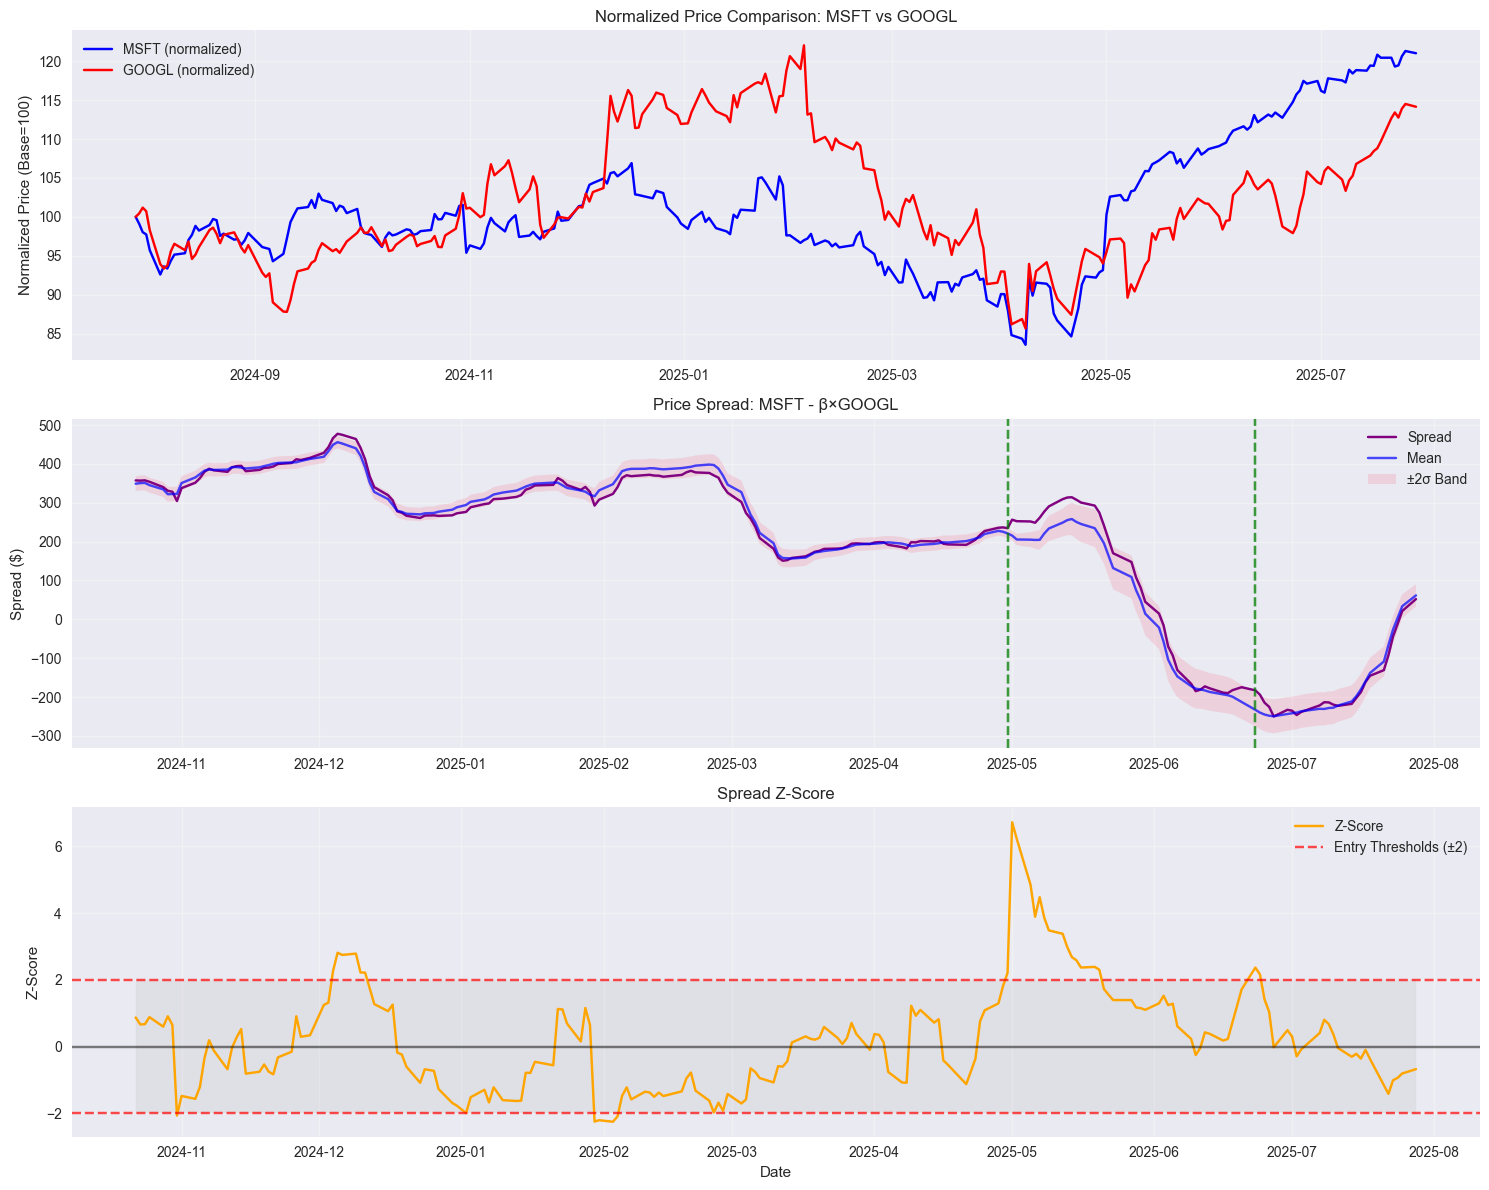


📊 MSFT-GOOGL Correlation: 0.428


In [22]:
# Pairs Arbitrage Strategy on MSFT vs GOOGL
if "MSFT" in data and "GOOGL" in data:
    print("⚖️ Running Pairs Arbitrage Strategy on MSFT vs GOOGL...")
    
    # Run backtest
    arb_signals, arb_trades, arb_metrics = arb_backtest(
        data["MSFT"], data["GOOGL"], "MSFT", "GOOGL",
        lookback_window=60,
        threshold=2.0,
        risk_params={
            "max_position": 25,
            "position_pct": 0.1,
            "stop_loss": 3.0,
            "max_hold_days": 20,
            "min_correlation": 0.6
        },
        starting_cash=100000,
        transaction_cost=0.001
    )
    
    # Display results
    print(f"\n🎯 Pairs Arbitrage Results:")
    for key, value in arb_metrics.items():
        if isinstance(value, float):
            if 'return' in key or 'rate' in key:
                print(f"   {key}: {value:.2%}")
            elif 'ratio' in key or 'drawdown' in key:
                print(f"   {key}: {value:.3f}")
            else:
                print(f"   {key}: {value:.2f}")
        elif isinstance(value, dict):
            print(f"   {key}: {value}")
        else:
            print(f"   {key}: {value}")
    
    # Plot spread analysis
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Price series
    ax1 = axes[0]
    # Normalize prices to show relative performance
    msft_norm = data["MSFT"]['last_price'] / data["MSFT"]['last_price'].iloc[0] * 100
    googl_norm = data["GOOGL"]['last_price'] / data["GOOGL"]['last_price'].iloc[0] * 100
    
    ax1.plot(msft_norm.index, msft_norm, label='MSFT (normalized)', color='blue')
    ax1.plot(googl_norm.index, googl_norm, label='GOOGL (normalized)', color='red')
    ax1.set_title('Normalized Price Comparison: MSFT vs GOOGL')
    ax1.set_ylabel('Normalized Price (Base=100)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Spread and Z-score
    ax2 = axes[1]
    ax2.plot(arb_signals.index, arb_signals['spread'], label='Spread', color='purple')
    ax2.plot(arb_signals.index, arb_signals['spread_mean'], label='Mean', color='blue', alpha=0.7)
    ax2.fill_between(arb_signals.index, 
                     arb_signals['spread_mean'] - 2*arb_signals['spread_std'],
                     arb_signals['spread_mean'] + 2*arb_signals['spread_std'],
                     alpha=0.2, label='±2σ Band')
    
    # Mark trades
    if arb_trades:
        trades_df = pd.DataFrame(arb_trades)
        entry_trades = trades_df[trades_df['reason'].str.contains('entry')]
        
        for _, trade in entry_trades.iterrows():
            ax2.axvline(x=trade['timestamp'], color='green', alpha=0.5, linestyle='--')
    
    ax2.set_title('Price Spread: MSFT - β×GOOGL')
    ax2.set_ylabel('Spread ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Z-score
    ax3 = axes[2]
    ax3.plot(arb_signals.index, arb_signals['z_score'], label='Z-Score', color='orange')
    ax3.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Entry Thresholds (±2)')
    ax3.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.fill_between(arb_signals.index, -2, 2, alpha=0.1, color='gray')
    
    ax3.set_title('Spread Z-Score')
    ax3.set_ylabel('Z-Score')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show correlation analysis
    correlation = data["MSFT"]['last_price'].corr(data["GOOGL"]['last_price'])
    print(f"\n📊 MSFT-GOOGL Correlation: {correlation:.3f}")

# 4. Strategy Comparison & Portfolio Analysis

📊 Strategy Performance Comparison

📈 Strategy Comparison Table:
       Strategy  Total Return  Sharpe Ratio  Max Drawdown  Total Trades  Win Rate  Final P&L
Trend Following       -0.0230        0.0000        0.0000             1    0.0000 -2297.3175
 Mean Reversion       -0.0096        0.0854       -0.0267             7    0.0105  -962.5162
Pairs Arbitrage       -0.0032       -0.2429       -0.0867             8    0.0175  -323.7479


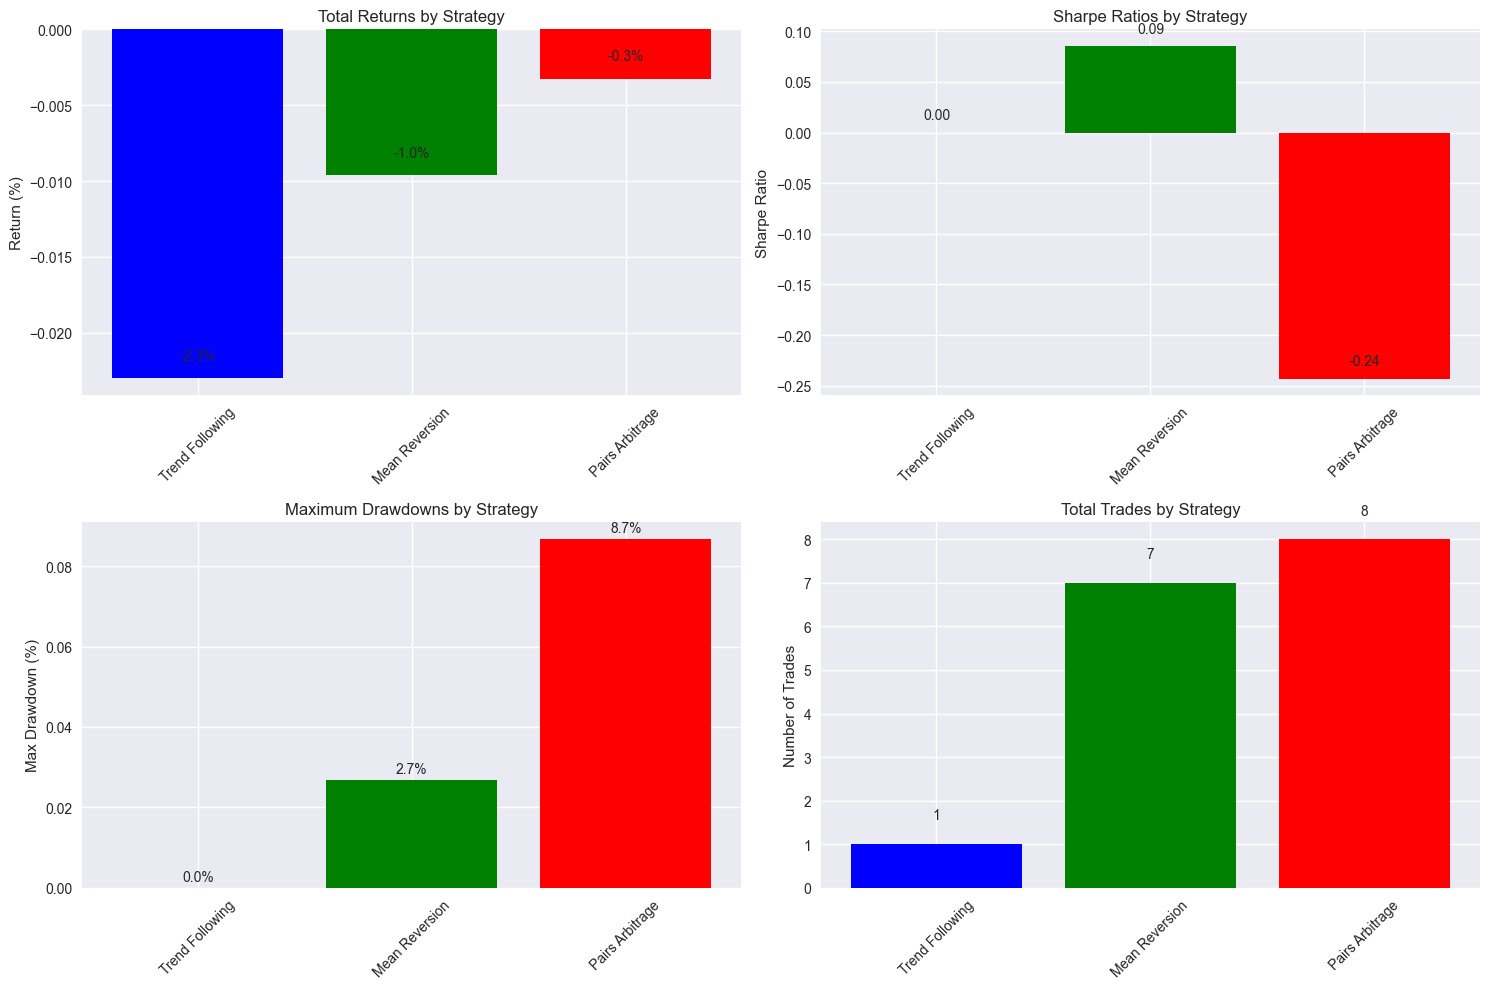

In [25]:
# Compare all strategies
print("📊 Strategy Performance Comparison")
print("=" * 50)

strategies = []
if 'tf_metrics' in locals():
    strategies.append(("Trend Following", tf_metrics))
if 'mr_metrics' in locals():
    strategies.append(("Mean Reversion", mr_metrics))
if 'arb_metrics' in locals():
    strategies.append(("Pairs Arbitrage", arb_metrics))

if strategies:
    # Create comparison DataFrame
    comparison_data = []
    for name, metrics in strategies:
        comparison_data.append({
            'Strategy': name,
            'Total Return': metrics.get('total_return', 0),
            'Sharpe Ratio': metrics.get('sharpe_ratio', 0),
            'Max Drawdown': metrics.get('max_drawdown', 0),
            'Total Trades': metrics.get('total_trades', 0),
            'Win Rate': metrics.get('win_rate', 0),
            'Final P&L': metrics.get('total_pnl', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n📈 Strategy Comparison Table:")
    print(comparison_df.round(4).to_string(index=False))
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Returns comparison
    ax1 = axes[0, 0]
    returns = [metrics.get('total_return', 0) for _, metrics in strategies]
    names = [name for name, _ in strategies]
    bars1 = ax1.bar(names, returns, color=['blue', 'green', 'red'][:len(names)])
    ax1.set_title('Total Returns by Strategy')
    ax1.set_ylabel('Return (%)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, ret in zip(bars1, returns):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{ret:.1%}', ha='center', va='bottom')
    
    # Sharpe ratio comparison
    ax2 = axes[0, 1]
    sharpes = [metrics.get('sharpe_ratio', 0) for _, metrics in strategies]
    bars2 = ax2.bar(names, sharpes, color=['blue', 'green', 'red'][:len(names)])
    ax2.set_title('Sharpe Ratios by Strategy')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, sharpe in zip(bars2, sharpes):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{sharpe:.2f}', ha='center', va='bottom')
    
    # Max drawdown comparison
    ax3 = axes[1, 0]
    drawdowns = [abs(metrics.get('max_drawdown', 0)) for _, metrics in strategies]
    bars3 = ax3.bar(names, drawdowns, color=['blue', 'green', 'red'][:len(names)])
    ax3.set_title('Maximum Drawdowns by Strategy')
    ax3.set_ylabel('Max Drawdown (%)')
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, dd in zip(bars3, drawdowns):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{dd:.1%}', ha='center', va='bottom')
    
    # Trade count comparison
    ax4 = axes[1, 1]
    trade_counts = [metrics.get('total_trades', 0) for _, metrics in strategies]
    bars4 = ax4.bar(names, trade_counts, color=['blue', 'green', 'red'][:len(names)])
    ax4.set_title('Total Trades by Strategy')
    ax4.set_ylabel('Number of Trades')
    ax4.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars4, trade_counts):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 5. Risk Management and Portfolio Metrics


In [26]:
# Advanced portfolio analysis
print("🎯 Advanced Portfolio Analytics")
print("=" * 40)

if strategies:
    # Risk-adjusted returns
    print("\n📊 Risk-Adjusted Performance:")
    for name, metrics in strategies:
        total_ret = metrics.get('total_return', 0)
        sharpe = metrics.get('sharpe_ratio', 0)
        max_dd = abs(metrics.get('max_drawdown', 0))
        
        # Calmar ratio (return / max drawdown)
        calmar = total_ret / max_dd if max_dd > 0 else 0
        
        print(f"\n{name}:")
        print(f"  📈 Total Return: {total_ret:.2%}")
        print(f"  ⚡ Sharpe Ratio: {sharpe:.3f}")
        print(f"  📉 Max Drawdown: {max_dd:.2%}")
        print(f"  🎯 Calmar Ratio: {calmar:.3f}")
        
        # Trade efficiency
        trades = metrics.get('total_trades', 0)
        if trades > 0:
            return_per_trade = total_ret / trades
            print(f"  🔄 Trades: {trades}")
            print(f"  💱 Return/Trade: {return_per_trade:.3%}")

# %% [markdown]
# ## 8. System Performance Summary

# %%
# Final system summary
print("🏆 Trading System Performance Summary")
print("=" * 45)

total_starting_cash = 100000 * len(strategies) if strategies else 100000
total_final_value = sum(metrics.get('starting_cash', 100000) + metrics.get('total_pnl', 0) 
                       for _, metrics in strategies)
total_pnl = sum(metrics.get('total_pnl', 0) for _, metrics in strategies)
total_return = total_pnl / total_starting_cash if total_starting_cash > 0 else 0

print(f"\n💰 Portfolio Summary:")
print(f"   Starting Capital: ${total_starting_cash:,.2f}")
print(f"   Final Value: ${total_final_value:,.2f}")
print(f"   Total P&L: ${total_pnl:,.2f}")
print(f"   Total Return: {total_return:.2%}")

print(f"\n🔧 System Components Tested:")
print(f"   ✅ MarketDataLoader: Multi-asset data retrieval")
print(f"   ✅ Order Management: Order validation and routing")
print(f"   ✅ LimitOrderBook: Price-time priority matching")
print(f"   ✅ PositionTracker: Real-time P&L calculation")
print(f"   ✅ Strategies: {len(strategies)} different approaches")

print(f"\n📈 Key Insights:")
if strategies:
    best_strategy = max(strategies, key=lambda x: x[1].get('total_return', 0))
    best_sharpe = max(strategies, key=lambda x: x[1].get('sharpe_ratio', 0))
    
    print(f"   🥇 Best Return: {best_strategy[0]} ({best_strategy[1].get('total_return', 0):.2%})")
    print(f"   ⚡ Best Sharpe: {best_sharpe[0]} ({best_sharpe[1].get('sharpe_ratio', 0):.3f})")
    
    total_trades = sum(metrics.get('total_trades', 0) for _, metrics in strategies)
    print(f"   🔄 Total Trades Executed: {total_trades}")

print(f"\n🎯 Next Steps:")
print(f"   • Implement live data feeds")
print(f"   • Add more sophisticated risk management")
print(f"   • Optimize strategy parameters")
print(f"   • Add transaction cost modeling")
print(f"   • Implement portfolio optimization")

print(f"\n✅ Trading System Simulation Complete!")

🎯 Advanced Portfolio Analytics

📊 Risk-Adjusted Performance:

Trend Following:
  📈 Total Return: -2.30%
  ⚡ Sharpe Ratio: 0.000
  📉 Max Drawdown: 0.00%
  🎯 Calmar Ratio: 0.000
  🔄 Trades: 1
  💱 Return/Trade: -2.297%

Mean Reversion:
  📈 Total Return: -0.96%
  ⚡ Sharpe Ratio: 0.085
  📉 Max Drawdown: 2.67%
  🎯 Calmar Ratio: -0.360
  🔄 Trades: 7
  💱 Return/Trade: -0.138%

Pairs Arbitrage:
  📈 Total Return: -0.32%
  ⚡ Sharpe Ratio: -0.243
  📉 Max Drawdown: 8.67%
  🎯 Calmar Ratio: -0.037
  🔄 Trades: 8
  💱 Return/Trade: -0.040%
🏆 Trading System Performance Summary

💰 Portfolio Summary:
   Starting Capital: $300,000.00
   Final Value: $296,416.42
   Total P&L: $-3,583.58
   Total Return: -1.19%

🔧 System Components Tested:
   ✅ MarketDataLoader: Multi-asset data retrieval
   ✅ Order Management: Order validation and routing
   ✅ LimitOrderBook: Price-time priority matching
   ✅ PositionTracker: Real-time P&L calculation
   ✅ Strategies: 3 different approaches

📈 Key Insights:
   🥇 Best Return: